In [222]:
# %pip install joblib matplotlib scikit-learn seaborn tensorflow
# %pip install scikeras ray
# %pip install "ray[train]"

In [223]:
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from statistics import mode
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, GRU, SimpleRNN, Conv1D, TimeDistributed, MaxPooling1D, Flatten, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Hyperparameter
import ray
from ray import train, tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.air.integrations.keras import ReportCheckpointCallback

from tensorflow.keras.optimizers import Adam, RMSprop
from functools import partial
from ray.tune.schedulers import ASHAScheduler


# Setting the random seeds for reproductibility
np.random.seed(42)
random.seed(42)

# Read Data Files

In [224]:

# File paths
file_path_healthy = './HIL Data 062024/ACC faults different scenarios/Sc5Healthy.csv'
file_path_delay = './HIL Data 062024/ACC faults different scenarios/Sc5DelayAPP.csv'
file_path_gain = './HIL Data 062024/ACC faults different scenarios/SC5GainAPP.csv'
file_path_noise = './HIL Data 062024/ACC faults different scenarios/Sc5NoiseAPP.csv'
file_path_loss = './HIL Data 062024/ACC faults different scenarios/Sc5PacketLossAPP.csv'

In [225]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to parse the general information section


def parse_general_info(lines):
    general_info = {}
    for line in lines:
        parts = line.split('\t')
        if len(parts) >= 3:
            category, key, value = parts[0], parts[1], parts[2]
            if category == "General":
                general_info[key] = value
    return general_info

# Function to parse the trace information section


def parse_trace_info(lines):
    trace_info = {}
    headers = lines[0].split('\t')
    for line in lines[1:]:
        values = line.split('\t')
        for i, header in enumerate(headers):
            if i < len(values):
                if header not in trace_info:
                    trace_info[header] = []
                trace_info[header].append(values[i])
    return trace_info

# Function to parse the trace values section


def parse_trace_values(lines):
    trace_values = [line.split(',') for line in lines]
    df = pd.DataFrame(trace_values[1:], columns=trace_values[0])
    return df

# Read the text data


def read_this(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Parse sections
    general_info_lines = []
    trace_info_lines = []
    trace_values_lines = []
    current_section = None

    for line in lines:
        line = line.strip()
        if 'descriptions' in line:
            current_section = 'general_info'
        elif 'trace_size' in line:
            current_section = 'trace_info'
        elif 'trace_values' in line:
            current_section = 'trace_values'
        elif line:
            if current_section == 'general_info':
                general_info_lines.append(line)
            elif current_section == 'trace_info':
                trace_info_lines.append(line)
            elif current_section == 'trace_values':
                trace_values_lines.append(line)

    # Process sections
    general_info = parse_general_info(general_info_lines)
    trace_info = parse_trace_info(trace_info_lines)
    trace_values = parse_trace_values(trace_values_lines)

    return general_info, trace_info, trace_values



# Labeling

In [226]:

# Read data
healthy_data = read_this(file_path_healthy)[2]
delay_app = read_this(file_path_delay)[2]
gain_rpm = read_this(file_path_gain)[2]
noise_app = read_this(file_path_noise)[2]
packetloss_app = read_this(file_path_loss)[2]

healthy_data = healthy_data.values.flatten()
delay_app = delay_app.values.flatten()
gain_rpm = gain_rpm.values.flatten()
noise_app = noise_app.values.flatten()
packetloss_app = packetloss_app.values.flatten()


In [227]:
# Function to clean and convert array elements to floats
def clean_and_convert(arr):
    cleaned_arr = []
    for x in arr:
        try:
            cleaned_arr.append(float(x))
        except ValueError:
            cleaned_arr.append(np.nan)
    return np.array(cleaned_arr)

healthy_data = clean_and_convert(healthy_data)
delay_app = clean_and_convert(delay_app)
gain_rpm = clean_and_convert(gain_rpm)
noise_app = clean_and_convert(noise_app)
packetloss_app = clean_and_convert(packetloss_app)


healthy_data = clean_and_convert(healthy_data)
delay_app = clean_and_convert(delay_app)
gain_rpm = clean_and_convert(gain_rpm)
noise_app = clean_and_convert(noise_app)
packetloss_app = clean_and_convert(packetloss_app)
packetloss_app

array([           nan, 1.00001400e-01, 1.25773025e+00, ...,
       8.41853221e+04, 1.17007348e+02, 1.14107881e+02])

In [228]:
print(healthy_data.shape) 
print(delay_app.shape)
print(gain_rpm.shape)
print(noise_app.shape)

(72045,)
(72108,)
(72423,)
(72126,)


In [229]:
def truncate_to_shortest_length(*arrays):
    min_length = min(len(arr) for arr in arrays)
    return [arr[:min_length] for arr in arrays]


# Truncate all arrays to the length of the shortest one
healthy_data, delay_app, gain_rpm, noise_app, packetloss_app = truncate_to_shortest_length(
    healthy_data, delay_app, gain_rpm, noise_app, packetloss_app
)


def calculate_diff_and_label(healthy, data, threshold_divisor):
    # Ensure the arrays are of the same shape
    if healthy.shape != data.shape:
        raise ValueError("The shapes of the input arrays do not match.")

    # Handle NaN values: replace NaNs with 0 for difference calculation
    healthy_clean = np.nan_to_num(healthy)
    data_clean = np.nan_to_num(data)

    # Calculate the absolute difference
    diff = np.abs(healthy_clean - data_clean)

    # Calculate the threshold, ignoring NaNs
    threshold = np.nanmax(healthy_clean, axis=0) / threshold_divisor

    # Generate labels based on the threshold
    label = (diff > threshold).astype(int)

    return label


label_gain = calculate_diff_and_label(healthy_data, gain_rpm, 3.5)
label_delay = calculate_diff_and_label(healthy_data, delay_app, 3.5)
label_loss = calculate_diff_and_label(healthy_data, packetloss_app, 3.5)
label_noise = calculate_diff_and_label(healthy_data, noise_app, 3.5)

# Convert NumPy arrays back to DataFrames
healthy_df = pd.DataFrame(healthy_data, columns=['data'])
delay_df = pd.DataFrame(delay_app, columns=['data'])
gain_df = pd.DataFrame(gain_rpm, columns=['data'])
noise_df = pd.DataFrame(noise_app, columns=['data'])
loss_df = pd.DataFrame(packetloss_app, columns=['data'])

loss_df

,data
0,NaN
1,0.100001
2,1.257730
3,772.746046
4,1.352379
...,...
72040,36.359528
72041,3016.958082
72042,84335.756253
72043,122.440090


In [230]:


# Add label columns
healthy_df['delay_class'] = 0
healthy_df['gain_class'] = 0
healthy_df['noise_class'] = 0
healthy_df['loss_class'] = 0

delay_df['delay_class'] = label_delay
delay_df['gain_class'] = 0
delay_df['noise_class'] = 0
delay_df['loss_class'] = 0

gain_df['gain_class'] = label_gain
gain_df['delay_class'] = 0
gain_df['noise_class'] = 0
gain_df['loss_class'] = 0

noise_df['noise_class'] = label_noise
noise_df['delay_class'] = 0
noise_df['gain_class'] = 0
noise_df['loss_class'] = 0

loss_df['loss_class'] = label_loss
loss_df['delay_class'] = 0
loss_df['gain_class'] = 0
loss_df['noise_class'] = 0

# Display the DataFrames to verify
print(healthy_df.head())
print(delay_df.head())
print(gain_df.head())
print(noise_df.head())
print(loss_df.head())

         data  delay_class  gain_class  noise_class  loss_class
0         NaN            0           0            0           0
1    0.115201            0           0            0           0
2    1.517328            0           0            0           0
3  731.739848            0           0            0           0
4    2.756631            0           0            0           0
         data  delay_class  gain_class  noise_class  loss_class
0         NaN            0           0            0           0
1    0.100002            0           0            0           0
2    1.063721            0           0            0           0
3  760.028930            0           0            0           0
4    4.812194            0           0            0           0
         data  gain_class  delay_class  noise_class  loss_class
0         NaN           0            0            0           0
1    0.100001           0            0            0           0
2    1.163056           0            0  

In [231]:
# Align columns before combining
all_dataframes = [healthy_df, delay_df, gain_df, noise_df, loss_df]
all_columns = list(set().union(*[df.columns for df in all_dataframes]))
for i in range(len(all_dataframes)):
    all_dataframes[i] = all_dataframes[i].reindex(
        columns=all_columns, fill_value=np.nan)

# Combine data
combined_data = pd.concat(all_dataframes, ignore_index=True)

combined_data

,loss_class,data,noise_class,gain_class,delay_class
0,0,NaN,0,0,0
1,0,0.115201,0,0,0
2,0,1.517328,0,0,0
3,0,731.739848,0,0,0
4,0,2.756631,0,0,0
...,...,...,...,...,...
360220,0,36.359528,0,0,0
360221,0,3016.958082,0,0,0
360222,0,84335.756253,0,0,0
360223,0,122.440090,0,0,0


In [232]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier

# Prepare the data for logistic regression
X = combined_data.iloc[:, 1:].values  # Features
y = combined_data[['delay_class', 'gain_class',
                   'noise_class', 'loss_class']].values  # Labels

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Train the logistic regression model using OneVsRestClassifier
model = OneVsRestClassifier(LogisticRegression(max_iter=10000))
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.9848011659379554
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       201
           2       1.00      1.00      1.00       358
           3       0.00      0.00      0.00      1095

   micro avg       1.00      0.42      0.59      1872
   macro avg       0.75      0.75      0.75      1872
weighted avg       0.42      0.42      0.42      1872
 samples avg       0.01      0.01      0.01      1872



/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Split the training data further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Train the logistic regression model using OneVsRestClassifier
model = OneVsRestClassifier(LogisticRegression(max_iter=10000))
model.fit(X_train, y_train)

# Predict on the validation data
y_val_pred = model.predict(X_val)

# Predict on the test data
y_test_pred = model.predict(X_test)

# Evaluate the model
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
val_report = classification_report(y_val, y_val_pred)
test_report = classification_report(y_test, y_test_pred)

print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Validation Classification Report:\n{val_report}")
print(f"Test Classification Report:\n{test_report}")


Validation Accuracy: 0.9842459573877438
Test Accuracy: 0.9848011659379554
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       184
           1       1.00      1.00      1.00       160
           2       1.00      1.00      1.00       307
           3       0.00      0.00      0.00       908

   micro avg       1.00      0.42      0.59      1559
   macro avg       0.75      0.75      0.75      1559
weighted avg       0.42      0.42      0.42      1559
 samples avg       0.01      0.01      0.01      1559

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       201
           2       1.00      1.00      1.00       358
           3       0.00      0.00      0.00      1095

   micro avg       1.00      0.42      0.59      1872
   macro avg       0.75      0.75      0.75      

/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

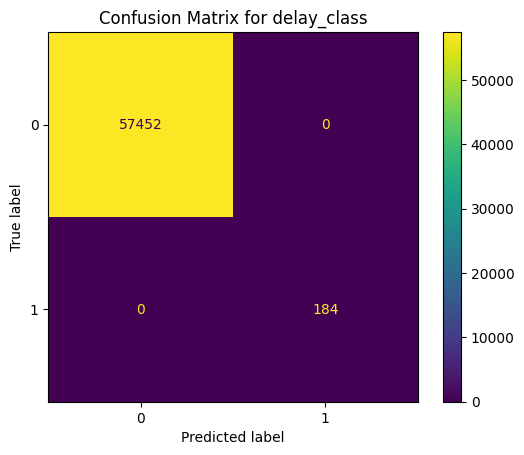

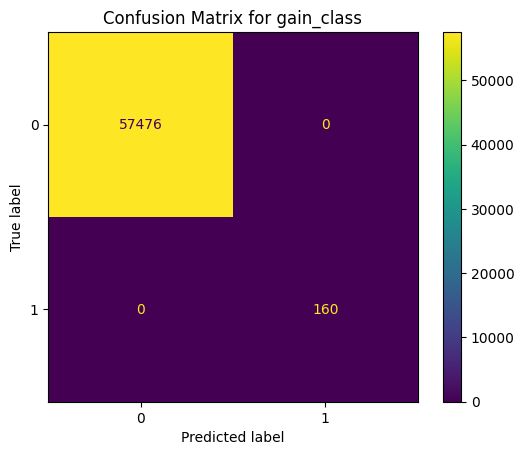

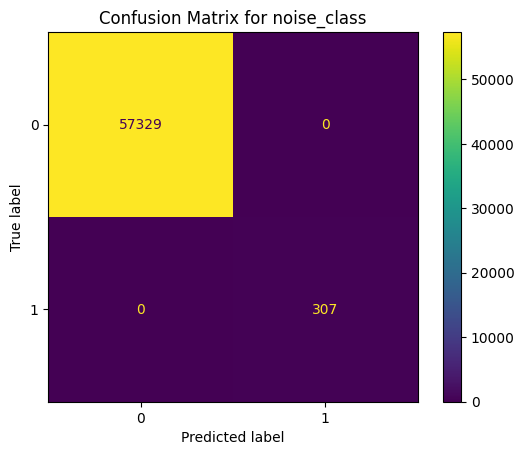

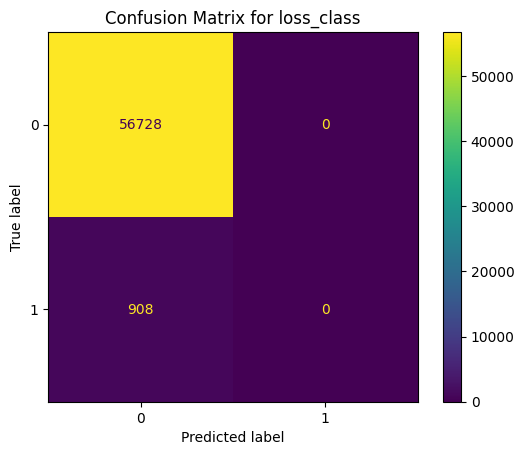

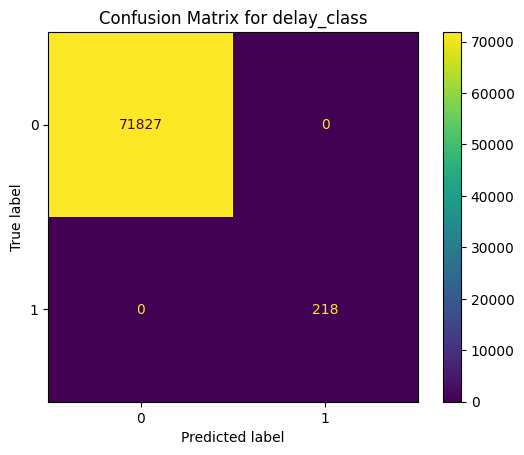

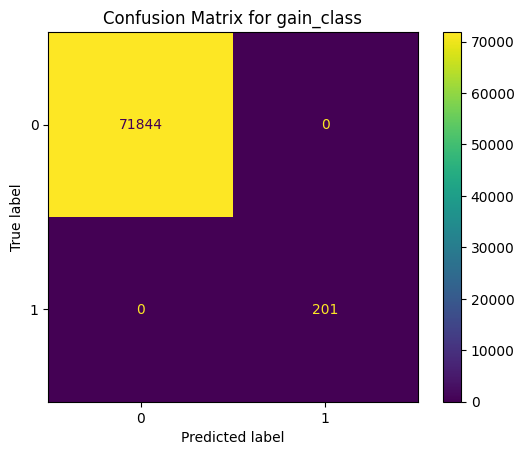

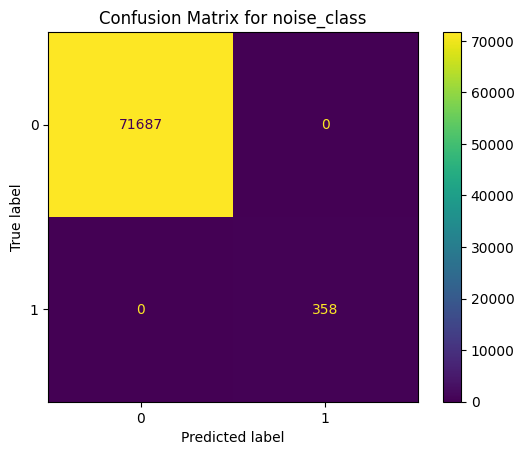

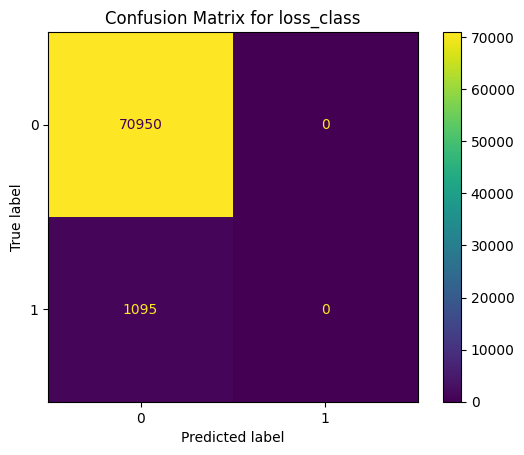

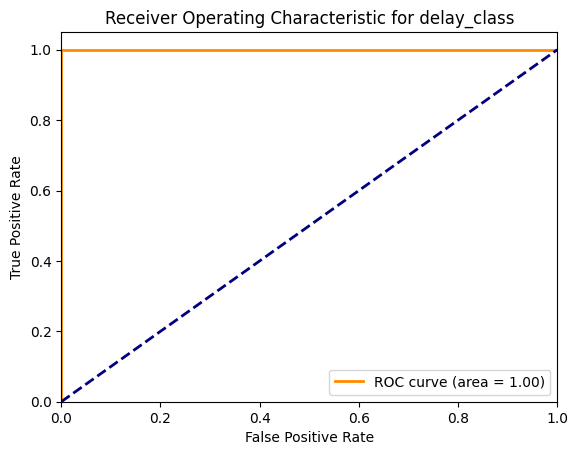

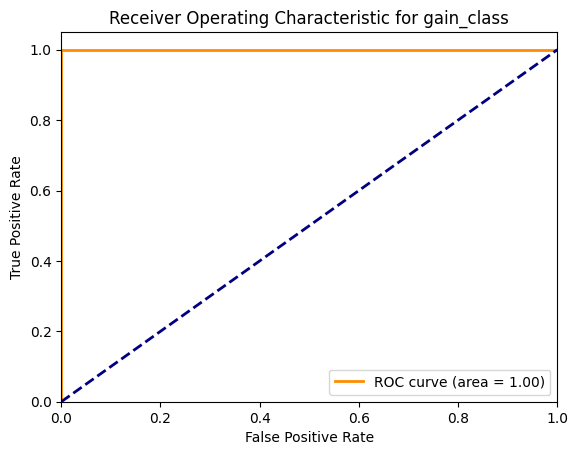

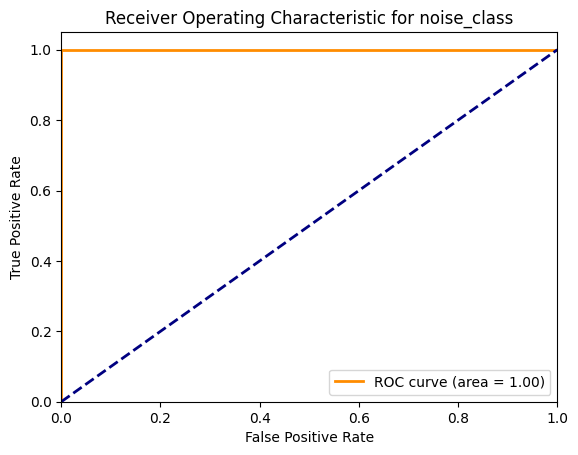

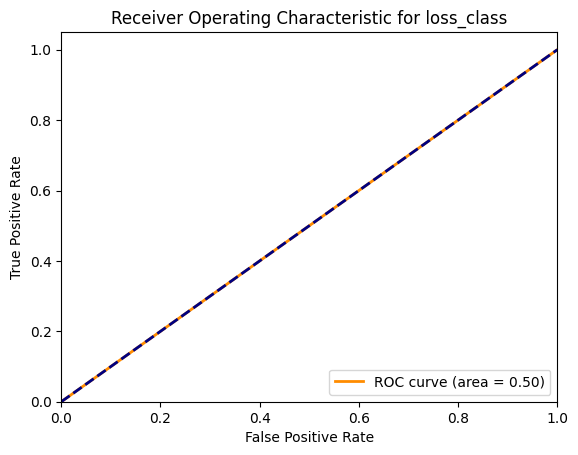

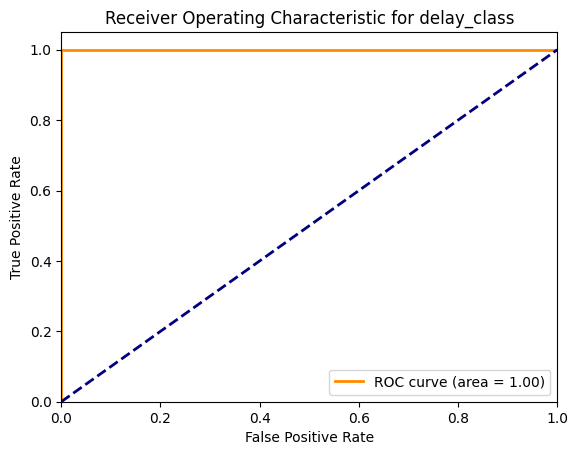

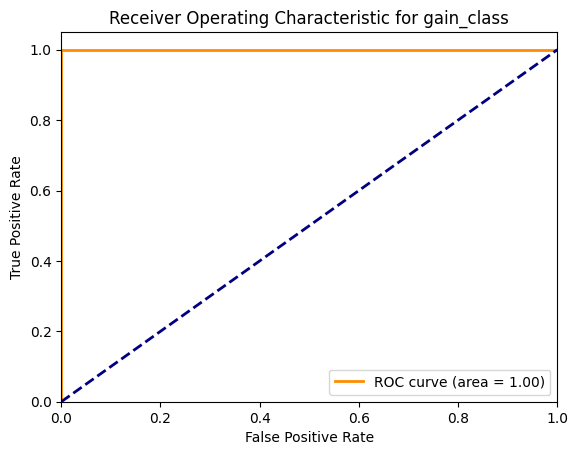

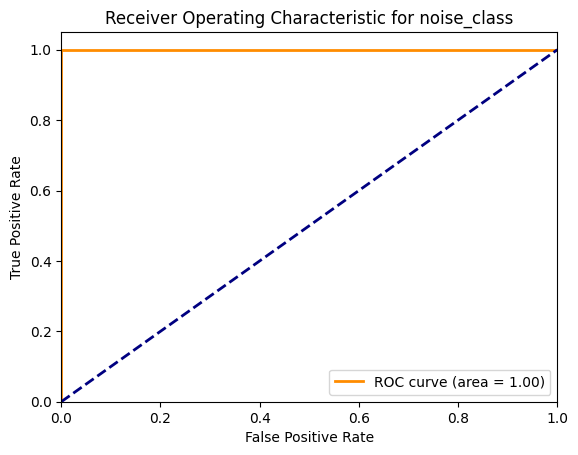

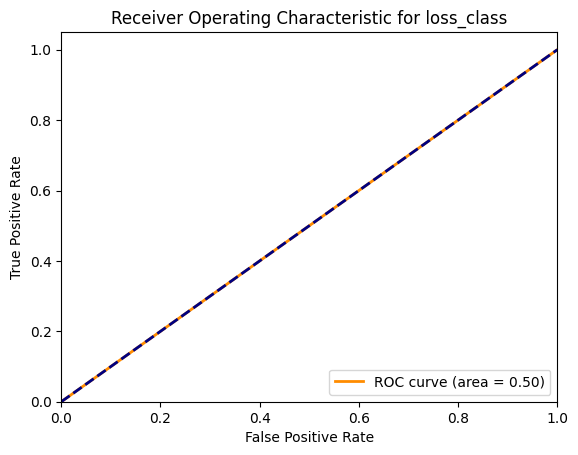

Loaded Test Accuracy: 0.9848011659379554
Loaded Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       201
           2       1.00      1.00      1.00       358
           3       0.00      0.00      0.00      1095

   micro avg       1.00      0.42      0.59      1872
   macro avg       0.75      0.75      0.75      1872
weighted avg       0.42      0.42      0.42      1872
 samples avg       0.01      0.01      0.01      1872



/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

In [234]:

# Function to plot confusion matrices for each class

def plot_confusion_matrices(y_true, y_pred, classes):
    for i, class_name in enumerate(classes):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f'Confusion Matrix for {class_name}')
        plt.show()


classes = ['delay_class', 'gain_class', 'noise_class', 'loss_class']
plot_confusion_matrices(y_val, y_val_pred, classes)
plot_confusion_matrices(y_test, y_test_pred, classes)

# Function to plot ROC curves for each class


def plot_roc_curves(y_true, y_pred, classes):
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {class_name}')
        plt.legend(loc="lower right")
        plt.show()


plot_roc_curves(y_val, y_val_pred, classes)
plot_roc_curves(y_test, y_test_pred, classes)

# Save the trained model
joblib.dump(model, 'logistic_regression_model.pkl')

# Load the trained model
loaded_model = joblib.load('logistic_regression_model.pkl')

# Predict with the loaded model
loaded_y_test_pred = loaded_model.predict(X_test)

# Evaluate the loaded model
loaded_test_accuracy = accuracy_score(y_test, loaded_y_test_pred)
loaded_test_report = classification_report(y_test, loaded_y_test_pred)

print(f"Loaded Test Accuracy: {loaded_test_accuracy}")
print(f"Loaded Test Classification Report:\n{loaded_test_report}")


Training model for delay_class...
Validation Accuracy for delay_class: 1.0
Test Accuracy for delay_class: 1.0
Validation Classification Report for delay_class:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71835
           1       1.00      1.00      1.00       210

    accuracy                           1.00     72045
   macro avg       1.00      1.00      1.00     72045
weighted avg       1.00      1.00      1.00     72045

Test Classification Report for delay_class:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71824
           1       1.00      1.00      1.00       221

    accuracy                           1.00     72045
   macro avg       1.00      1.00      1.00     72045
weighted avg       1.00      1.00      1.00     72045



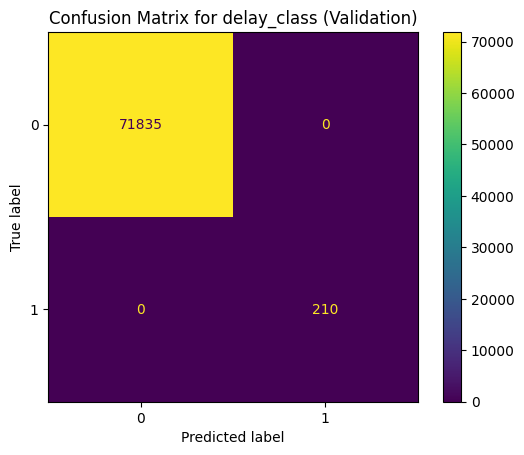

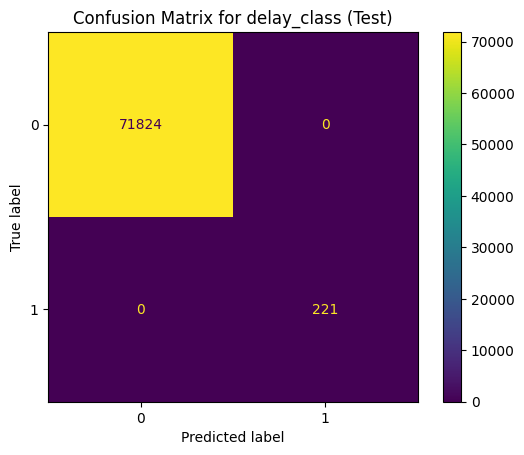

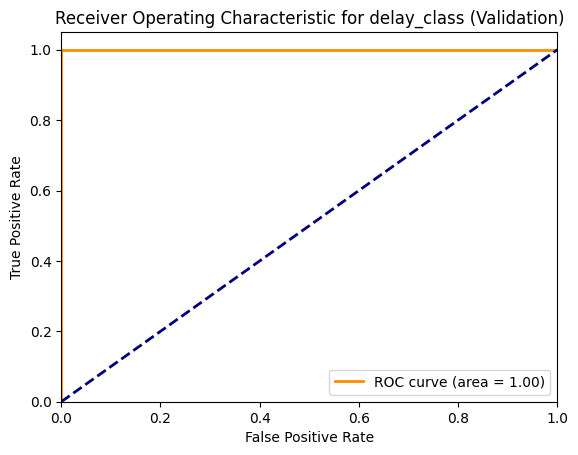

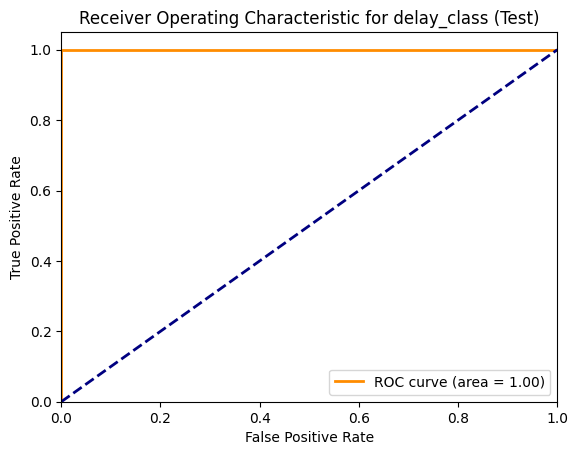


Training model for gain_class...
Validation Accuracy for gain_class: 1.0
Test Accuracy for gain_class: 1.0
Validation Classification Report for gain_class:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71844
           1       1.00      1.00      1.00       201

    accuracy                           1.00     72045
   macro avg       1.00      1.00      1.00     72045
weighted avg       1.00      1.00      1.00     72045

Test Classification Report for gain_class:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71848
           1       1.00      1.00      1.00       197

    accuracy                           1.00     72045
   macro avg       1.00      1.00      1.00     72045
weighted avg       1.00      1.00      1.00     72045



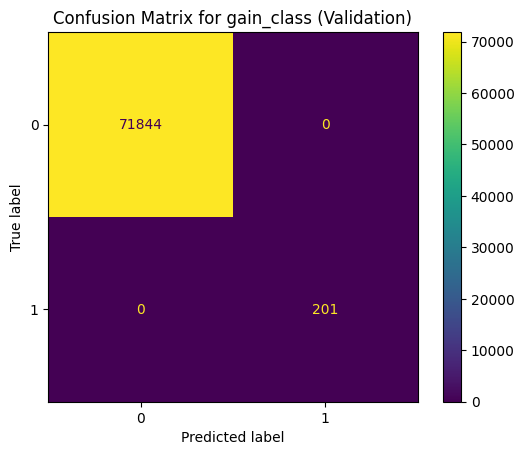

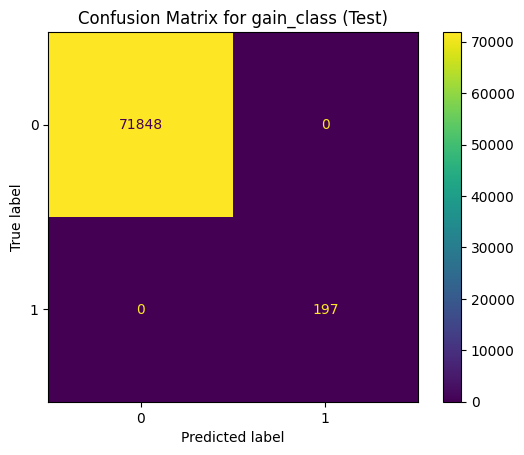

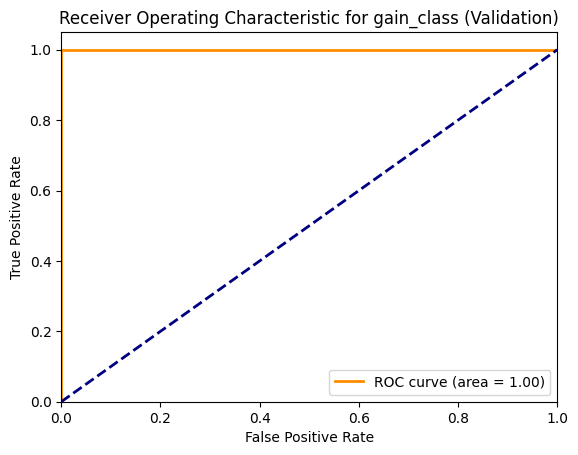

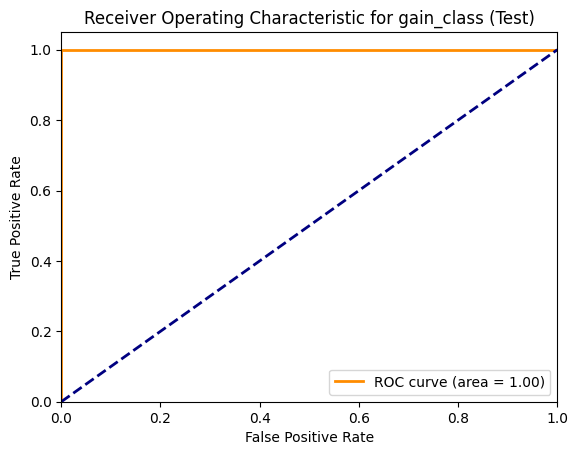


Training model for noise_class...
Validation Accuracy for noise_class: 1.0
Test Accuracy for noise_class: 1.0
Validation Classification Report for noise_class:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71694
           1       1.00      1.00      1.00       351

    accuracy                           1.00     72045
   macro avg       1.00      1.00      1.00     72045
weighted avg       1.00      1.00      1.00     72045

Test Classification Report for noise_class:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71684
           1       1.00      1.00      1.00       361

    accuracy                           1.00     72045
   macro avg       1.00      1.00      1.00     72045
weighted avg       1.00      1.00      1.00     72045



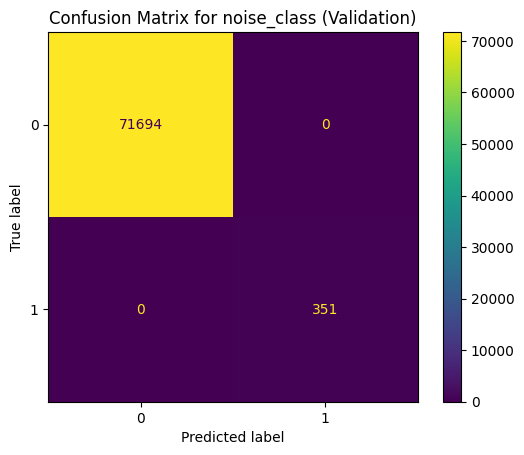

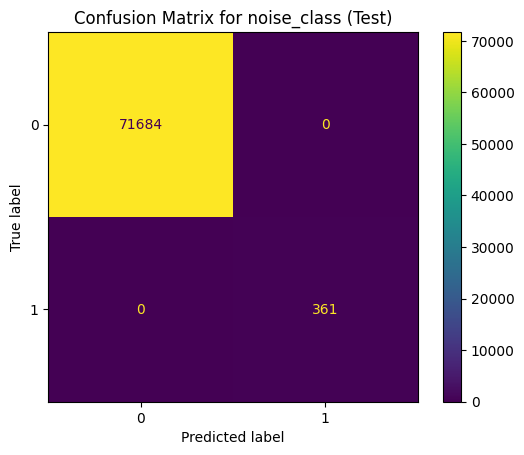

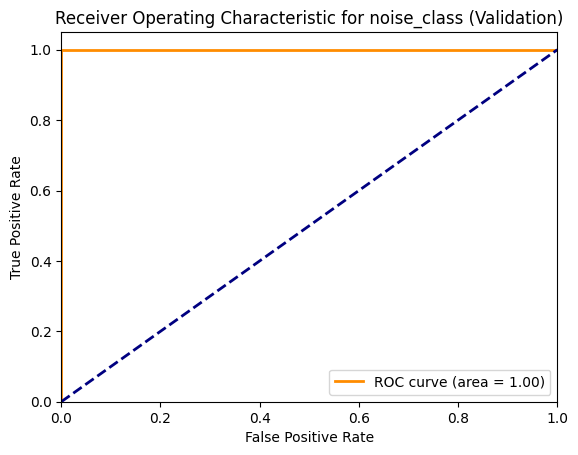

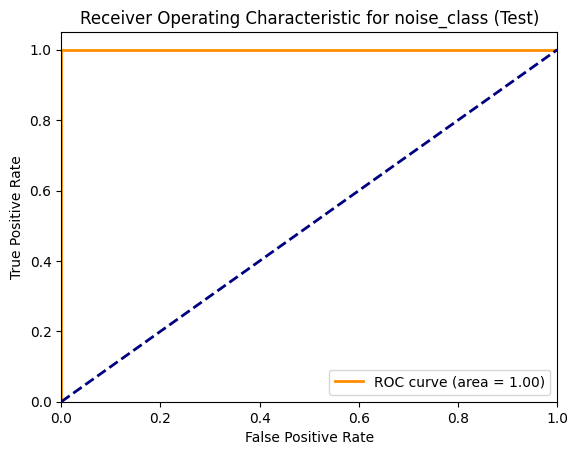


Training model for loss_class...
Validation Accuracy for loss_class: 0.9845929627316261
Test Accuracy for loss_class: 0.9843569990977861
Validation Classification Report for loss_class:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     70935
           1       0.00      0.00      0.00      1110

    accuracy                           0.98     72045
   macro avg       0.49      0.50      0.50     72045
weighted avg       0.97      0.98      0.98     72045

Test Classification Report for loss_class:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     70918
           1       0.00      0.00      0.00      1127

    accuracy                           0.98     72045
   macro avg       0.49      0.50      0.50     72045
weighted avg       0.97      0.98      0.98     72045



/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

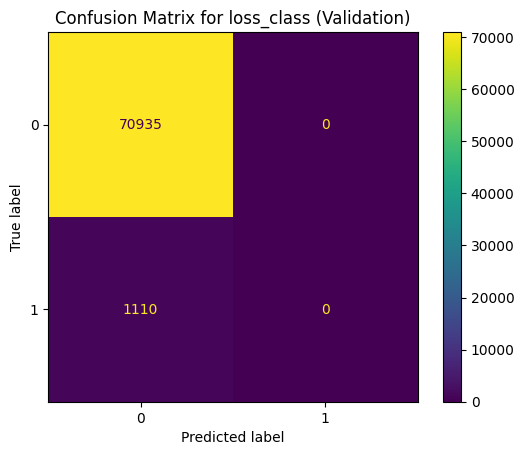

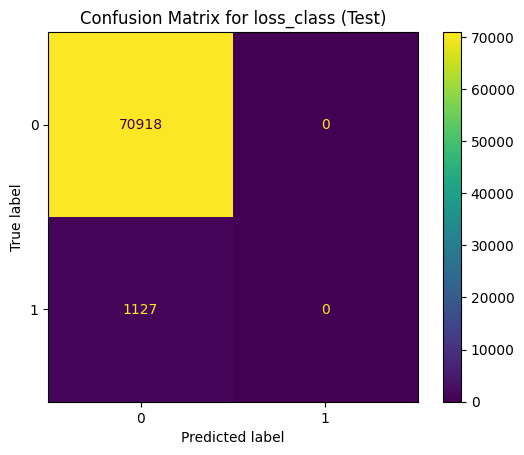

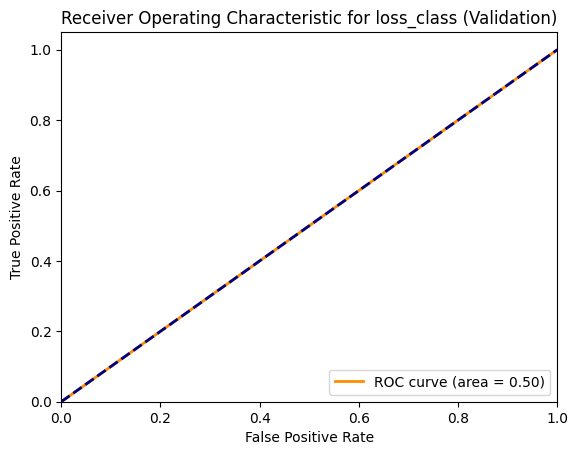

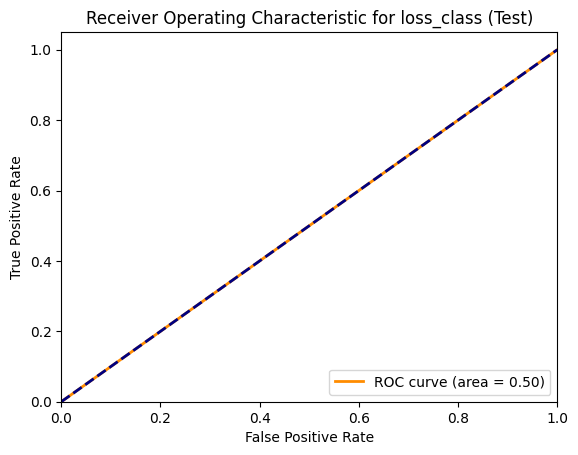

Loaded Test Accuracy for delay_class: 0.9812894718578666
Loaded Test Classification Report for delay_class:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     70918
           1       0.00      0.00      0.00      1127

    accuracy                           0.98     72045
   macro avg       0.49      0.50      0.50     72045
weighted avg       0.97      0.98      0.98     72045

Loaded Test Accuracy for gain_class: 0.9816225969879936
Loaded Test Classification Report for gain_class:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     70918
           1       0.00      0.00      0.00      1127

    accuracy                           0.98     72045
   macro avg       0.49      0.50      0.50     72045
weighted avg       0.97      0.98      0.98     72045

Loaded Test Accuracy for noise_class: 0.9793462419321257
Loaded Test Classification Report for noise_class:
              precision 

/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [239]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import joblib
import numpy as np

# Assuming your data is loaded in combined_data
# Prepare the data for logistic regression
X = combined_data.iloc[:, 1:].values  # Features
y_all = combined_data[['delay_class', 'gain_class',
                       'noise_class', 'loss_class']]  # Labels as DataFrame

# Define the classes
classes = ['delay_class', 'gain_class', 'noise_class', 'loss_class']

# Initialize dictionaries to store models and their results
models = {}
val_accuracies = {}
test_accuracies = {}
val_reports = {}
test_reports = {}

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Train and evaluate a model for each class
for class_name in classes:
    print(f"\nTraining model for {class_name}...")

    # Split the data for the current class
    y = y_all[class_name].values
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42)

    # Train the logistic regression model
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)

    # Save the trained model
    joblib.dump(model, f'{class_name}_model.pkl')
    models[class_name] = model

    # Predict on the validation data
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Evaluate the model
    val_accuracies[class_name] = accuracy_score(y_val, y_val_pred)
    test_accuracies[class_name] = accuracy_score(y_test, y_test_pred)
    val_reports[class_name] = classification_report(y_val, y_val_pred)
    test_reports[class_name] = classification_report(y_test, y_test_pred)

    print(f"Validation Accuracy for {class_name}: {val_accuracies[class_name]}")
    print(f"Test Accuracy for {class_name}: {test_accuracies[class_name]}")
    print(f"Validation Classification Report for {class_name}:\n{val_reports[class_name]}")
    print(f"Test Classification Report for {class_name}:\n{test_reports[class_name]}")

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {class_name} (Validation)')
    plt.show()

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {class_name} (Test)')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {class_name} (Validation)')
    plt.legend(loc="lower right")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {class_name} (Test)')
    plt.legend(loc="lower right")
    plt.show()

# Load the models and re-evaluate on the test data to confirm they were saved and loaded correctly
for class_name in classes:
    loaded_model = joblib.load(f'{class_name}_model.pkl')
    y_test_pred = loaded_model.predict(X_test)
    loaded_test_accuracy = accuracy_score(y_test, y_test_pred)
    loaded_test_report = classification_report(y_test, y_test_pred)

    print(f"Loaded Test Accuracy for {class_name}: {loaded_test_accuracy}")
    print(f"Loaded Test Classification Report for {class_name}:\n{loaded_test_report}")

## CONCURRENT FAULTS DETECTION